In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import json

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.isri import ISRIStemmer
from collections import Counter
import itertools
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from joblib import dump, load

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import shutil
import pandas as pd
import subprocess

# Extract 7z file using 7z command-line tool
def extract_7z(file_path):
    subprocess.run(['7z', 'x', file_path])

# Function to read text files from directories
def read_text_files(directory):
    text_data = []
    for subdir, dirs, files in os.walk(directory):
        if files:
            label = os.path.basename(subdir)
            for file in files:
                if file.endswith(".txt"):
                    file_path = os.path.join(subdir, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                        text_data.append((text, label))
    return text_data

# Extract the 7z file
extract_7z("/content/cnn-arabic-utf8.7z")

# Read text files and create dataset
data = read_text_files("./cnn-arabic-utf8")

# Create DataFrame
df = pd.DataFrame(data, columns=['text', 'category'])

# Save DataFrame to CSV file
df.to_csv("dataset.csv", index=False)

# Check for and drop rows with any null values
print("Number of rows with null values before dropping:", df.isnull().any(axis=1).sum())
clean_df = df.dropna()
print("Number of rows with null values after dropping:", clean_df.isnull().any(axis=1).sum())


Number of rows with null values before dropping: 0
Number of rows with null values after dropping: 0


In [ ]:
clean_df

,text,category
0,CNNArabic.com - أمريكا: نائب يرفض إص...,entertainment
1,CNNArabic.com - عراقيون وإيرانيون: ه...,entertainment
2,"CNNArabic.com - مدونات: الفرق بين ""ا...",entertainment
3,CNNArabic.com - عند افتتاحه.. يمكنك ...,entertainment
4,"CNNArabic.com - طيار يمارس ""الجنس ال...",entertainment
...,...,...
5065,CNNArabic.com - أسهم الكويت تنهي أسب...,business
5066,CNNArabic.com - استطلاع: ُخمس الأمري...,business
5067,"CNNArabic.com - ""بلاك روك"" تشتري بار...",business
5068,CNNArabic.com - دبي: لن نضمن ديون ال...,business


In [ ]:
print (df.notnull().any(axis = 0))


text        True
category    True
dtype: bool


In [ ]:
def remove_hashtag(df, col='text'):
    special_characters = r'#[\].!XR'
    for letter in special_characters:
        df[col] = df[col].astype(str).str.replace(letter, '', regex=False)


In [ ]:
remove_hashtag(clean_df)
clean_df

,text,category
0,CNNArabiccom - أمريكا: نائب يرفض إصد...,entertainment
1,CNNArabiccom - عراقيون وإيرانيون: هس...,entertainment
2,"CNNArabiccom - مدونات: الفرق بين ""ال...",entertainment
3,CNNArabiccom - عند افتتاحه يمكنك الو...,entertainment
4,"CNNArabiccom - طيار يمارس ""الجنس الج...",entertainment
...,...,...
5065,CNNArabiccom - أسهم الكويت تنهي أسبو...,business
5066,CNNArabiccom - استطلاع: ُخمس الأمريك...,business
5067,"CNNArabiccom - ""بلاك روك"" تشتري بارك...",business
5068,CNNArabiccom - دبي: لن نضمن ديون الش...,business


In [ ]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
def processDocument(doc, stemmer):

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', '', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    doc= remove_punctuations(doc)
    # normalize the tweet
    doc= normalize_arabic(doc)
    # remove repeated letters
    doc=remove_repeating_char(doc)
    #stemming
    doc = stemmer.stem(doc)

    return doc

stemmer = ISRIStemmer()
clean_df["text"] = clean_df['text'].apply(lambda x: processDocument(x, stemmer))
clean_df

,text,category
0,امريكا نائب يرفض اصدار طابع لجاكسون المتحرش ب...,entertainment
1,عراقيون وايرانيون هس باراك اوباما شيعي عراقيو...,entertainment
2,مدونات الفرق بين المجاهر والسعودين وهبه نجيب ...,entertainment
3,عند افتاحه يمكنك الوصول الي قمه برج دبي بدقيق...,entertainment
4,طيار يمارس الجنس الجوي في مروحيته طيار يمارس ...,entertainment
...,...,...
5065,اسهم الكويت تنهي اسبوعها مرتفعه والاماراتيه ت...,business
5066,استطلاع خمس الامريكين يحملون الحزبين مسؤوليه ...,business
5067,بلاك روك تشتري باركليز لاستثمار مقابل مليار ب...,business
5068,دبي لن نضمن ديون الشركات ونواجه منافسه غير شر...,business


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
clean_df["text"] = clean_df["text"].apply(tokenizer.tokenize)
# print(clean_df['text'].values[0])
clean_df

,text,category
0,"[امريكا, نائب, يرفض, اصدار, طابع, لجاكسون, الم...",entertainment
1,"[عراقيون, وايرانيون, هس, باراك, اوباما, شيعي, ...",entertainment
2,"[مدونات, الفرق, بين, المجاهر, والسعودين, وهبه,...",entertainment
3,"[عند, افتاحه, يمكنك, الوصول, الي, قمه, برج, دب...",entertainment
4,"[طيار, يمارس, الجنس, الجوي, في, مروحيته, طيار,...",entertainment
...,...,...
5065,"[اسهم, الكويت, تنهي, اسبوعها, مرتفعه, والامارا...",business
5066,"[استطلاع, خمس, الامريكين, يحملون, الحزبين, مسؤ...",business
5067,"[بلاك, روك, تشتري, باركليز, لاستثمار, مقابل, م...",business
5068,"[دبي, لن, نضمن, ديون, الشركات, ونواجه, منافسه,...",business


In [ ]:
stopwords_list = stopwords.words('arabic')
listToStr = ' '.join([str(elem) for elem in stopwords_list])
print(listToStr)

إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هنا

In [ ]:
clean_df["text"] = clean_df["text"].apply(lambda x: [item for item in x if item not in stopwords_list])
clean_df

,text,category
0,"[امريكا, نائب, يرفض, اصدار, طابع, لجاكسون, الم...",entertainment
1,"[عراقيون, وايرانيون, هس, باراك, اوباما, شيعي, ...",entertainment
2,"[مدونات, الفرق, المجاهر, والسعودين, وهبه, نجيب...",entertainment
3,"[افتاحه, يمكنك, الوصول, الي, قمه, برج, دبي, بد...",entertainment
4,"[طيار, يمارس, الجنس, الجوي, مروحيته, طيار, يما...",entertainment
...,...,...
5065,"[اسهم, الكويت, تنهي, اسبوعها, مرتفعه, والامارا...",business
5066,"[استطلاع, الامريكين, يحملون, الحزبين, مسؤوليه,...",business
5067,"[بلاك, روك, تشتري, باركليز, لاستثمار, مقابل, م...",business
5068,"[دبي, نضمن, ديون, الشركات, ونواجه, منافسه, شري...",business


In [ ]:
def countPropetries(df):
    all_words = [word for tokens in df["text"] for word in tokens]
    sentence_lengths = [len(tokens) for tokens in df["text"]]

    VOCAB = sorted(list(set(all_words)))

    print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
    print("Max sentence length is %s" % max(sentence_lengths))
    return all_words

In [ ]:
import pandas as pd

# Charger le DataFrame à partir du fichier CSV
df = pd.read_csv("dataset.csv")

# Afficher les différentes catégories
categories = df['category'].unique()
print("Différentes catégories :")
for category in categories:
    print(category)


Différentes catégories :
entertainment
middle_east
world
sport
scitech
business


In [ ]:
entertainment_df = clean_df.loc[clean_df["category"] == "entertainment"]
middle_east_df = clean_df.loc[clean_df["category"] == "middle_east"]
world_df = clean_df.loc[clean_df["category"] == "world"]
sport_df = clean_df.loc[clean_df["category"] == "sport"]
scitech_df = clean_df.loc[clean_df["category"] == "scitech"]
business_df = clean_df.loc[clean_df["category"] == "business"]

print("Entertainment : ")
entertainment_words = countPropetries(entertainment_df)
print("\nmiddle_east : ")
middle_east_words = countPropetries(middle_east_df)
print("\nworld : ")
world_words = countPropetries(world_df)
print("\nsport : ")
sport_words = countPropetries(sport_df)
print("\nscitech : ")
scitech_words = countPropetries(scitech_df)
print("\nbusiness : ")
business_words = countPropetries(business_df)

Entertainment : 
170465 words total, with a vocabulary size of 35139
Max sentence length is 1183

middle_east : 
601325 words total, with a vocabulary size of 51641
Max sentence length is 1689

world : 
338883 words total, with a vocabulary size of 32963
Max sentence length is 4353

sport : 
252077 words total, with a vocabulary size of 25889
Max sentence length is 2546

scitech : 
157510 words total, with a vocabulary size of 25436
Max sentence length is 743

business : 
302445 words total, with a vocabulary size of 24903
Max sentence length is 1786


In [ ]:
def plot(all_words, title):
    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(25):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10

    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)

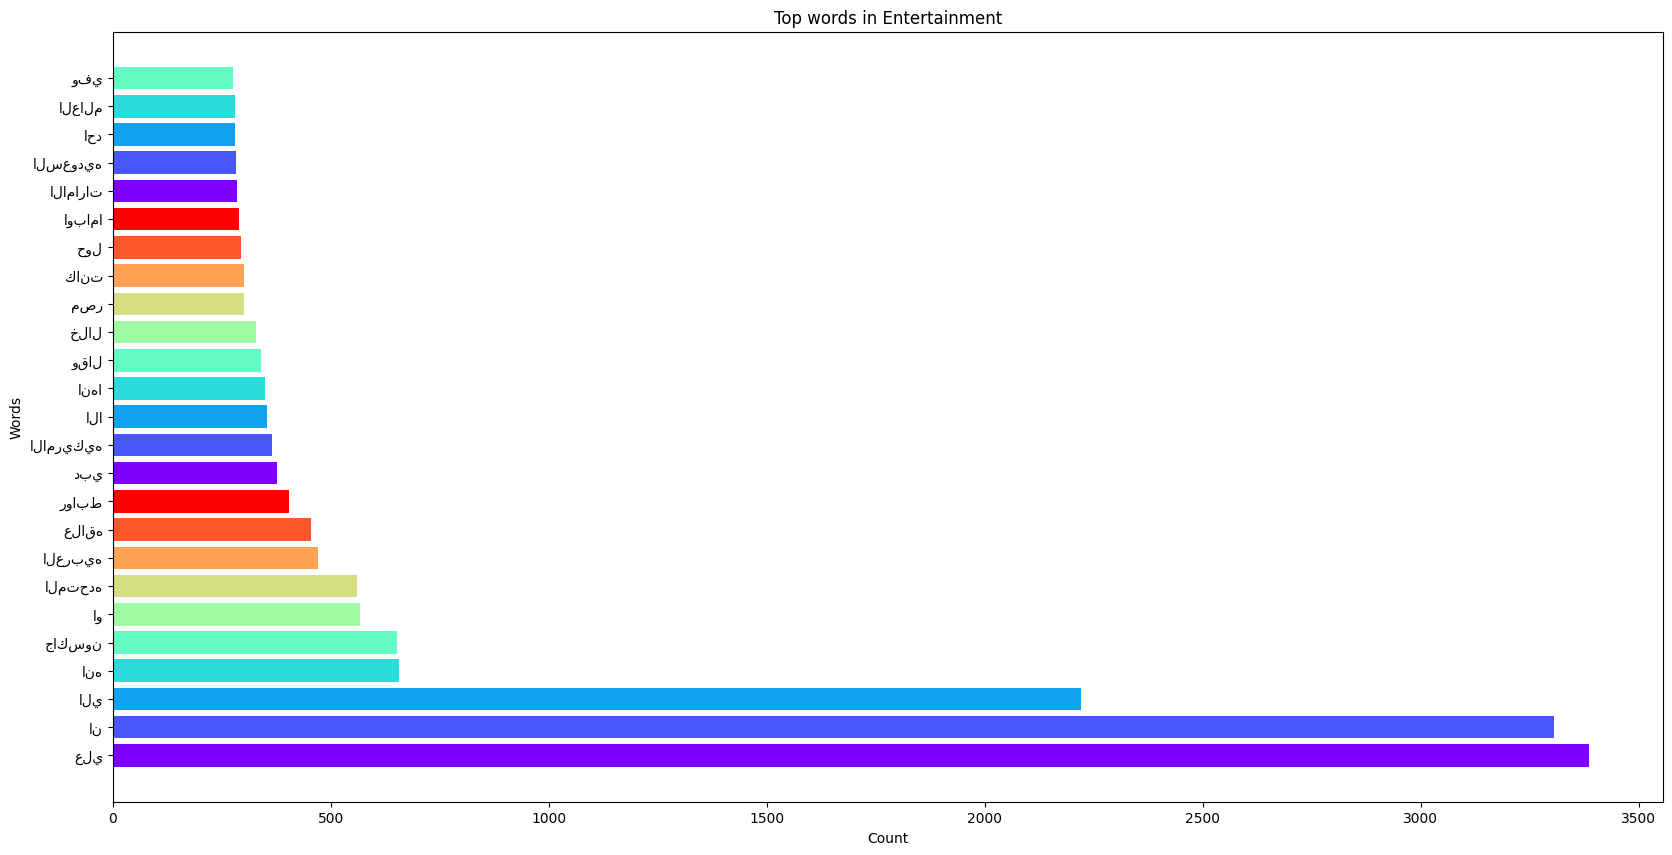

In [ ]:
plot(entertainment_words, 'Top words in Entertainment')

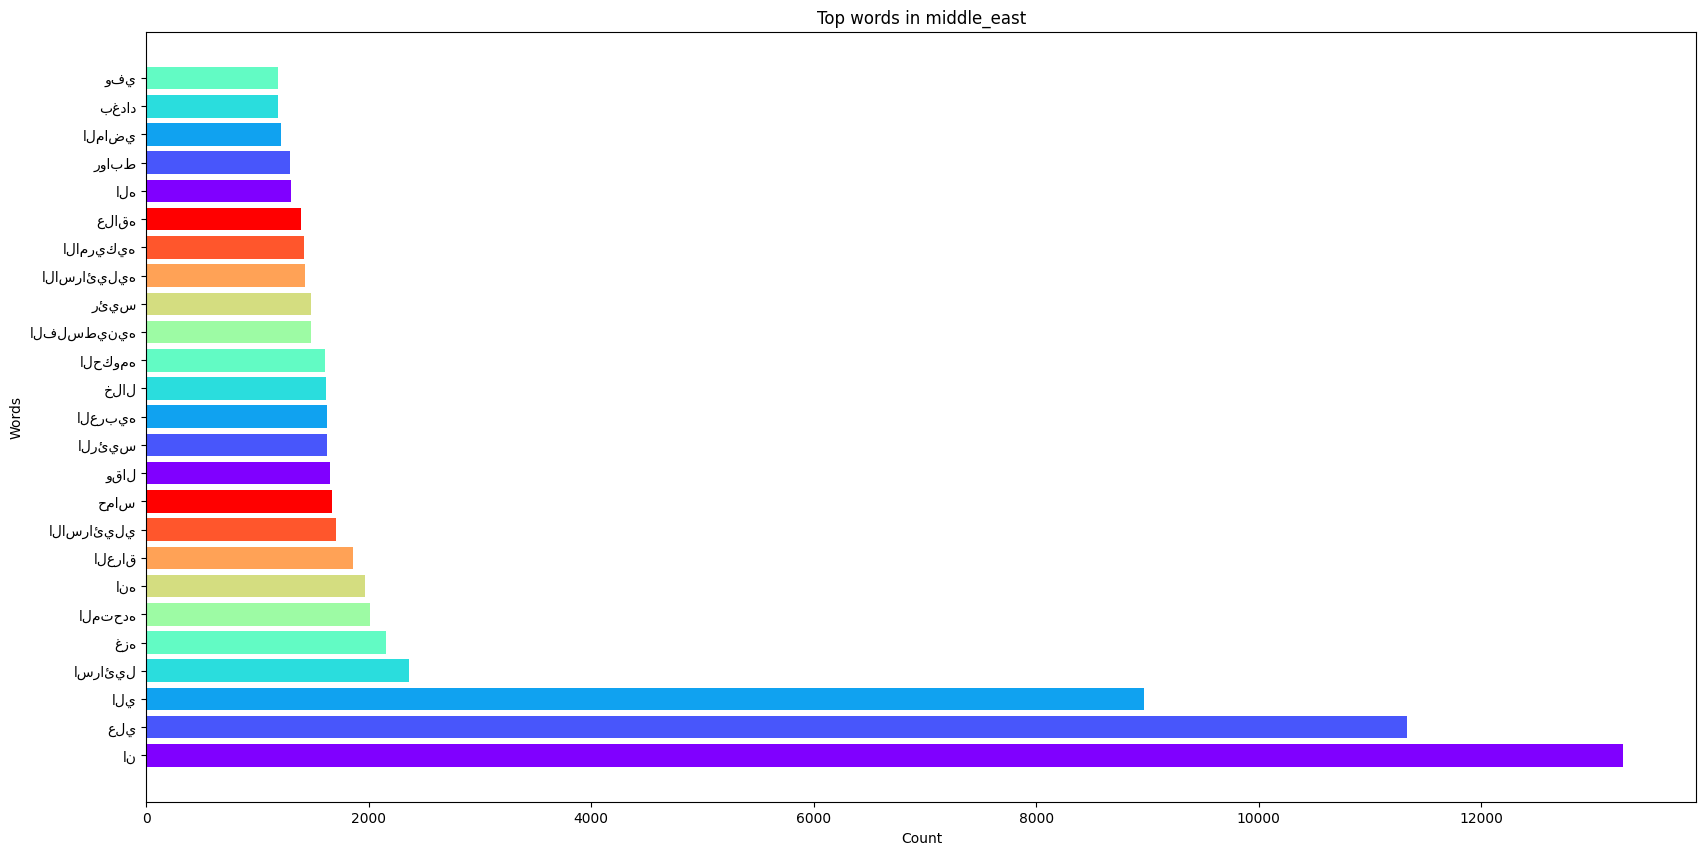

In [ ]:
plot(middle_east_words, 'Top words in middle_east')

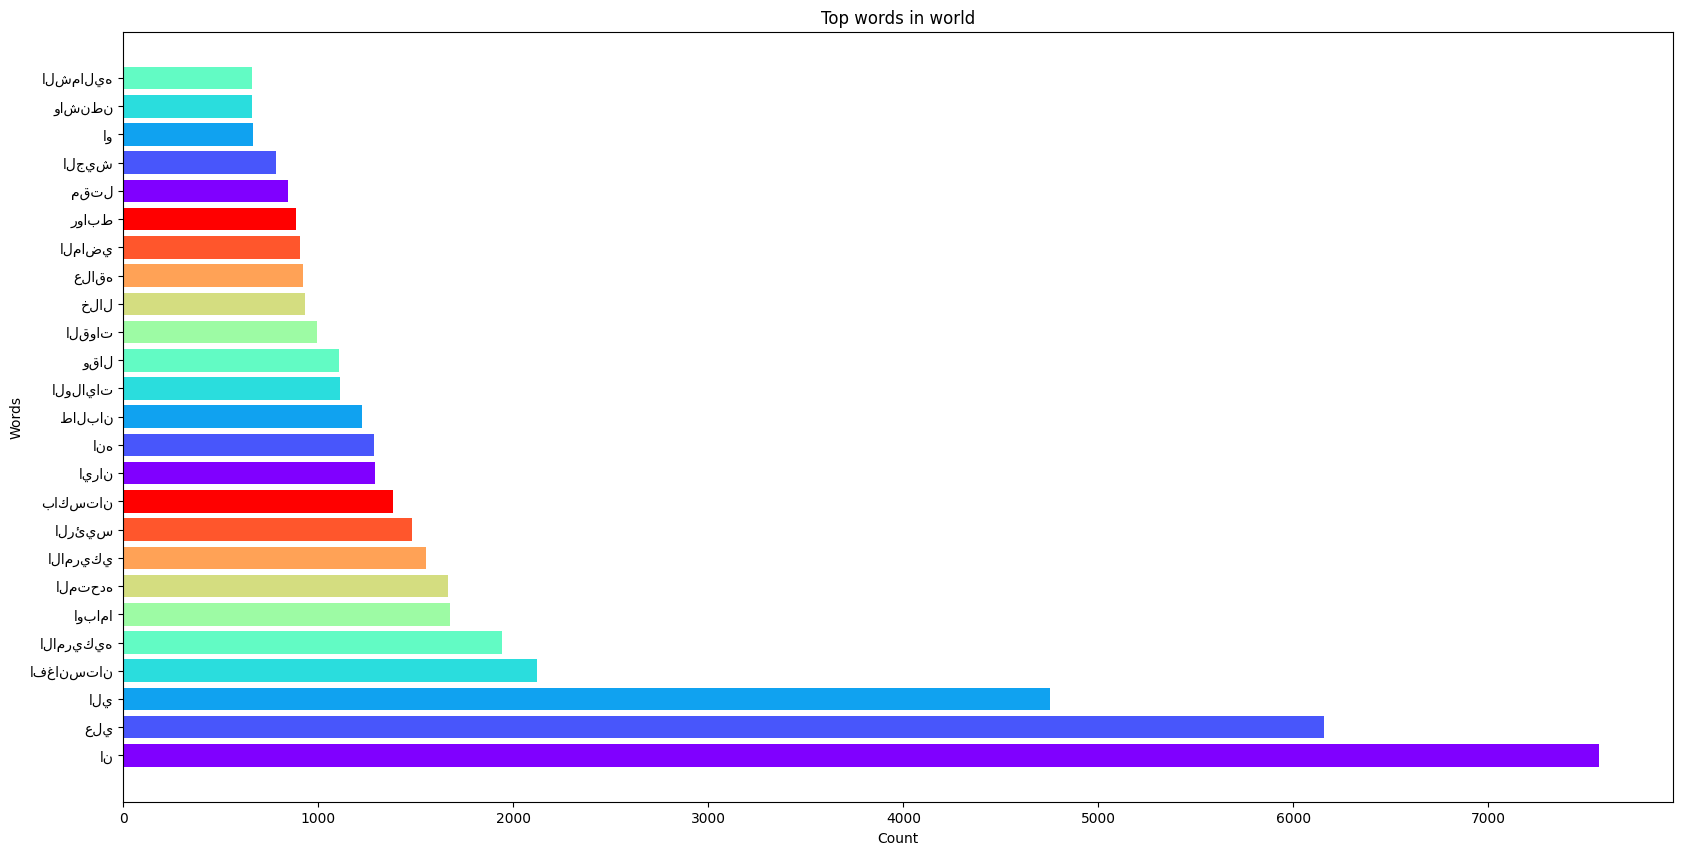

In [ ]:
plot(world_words, 'Top words in world')

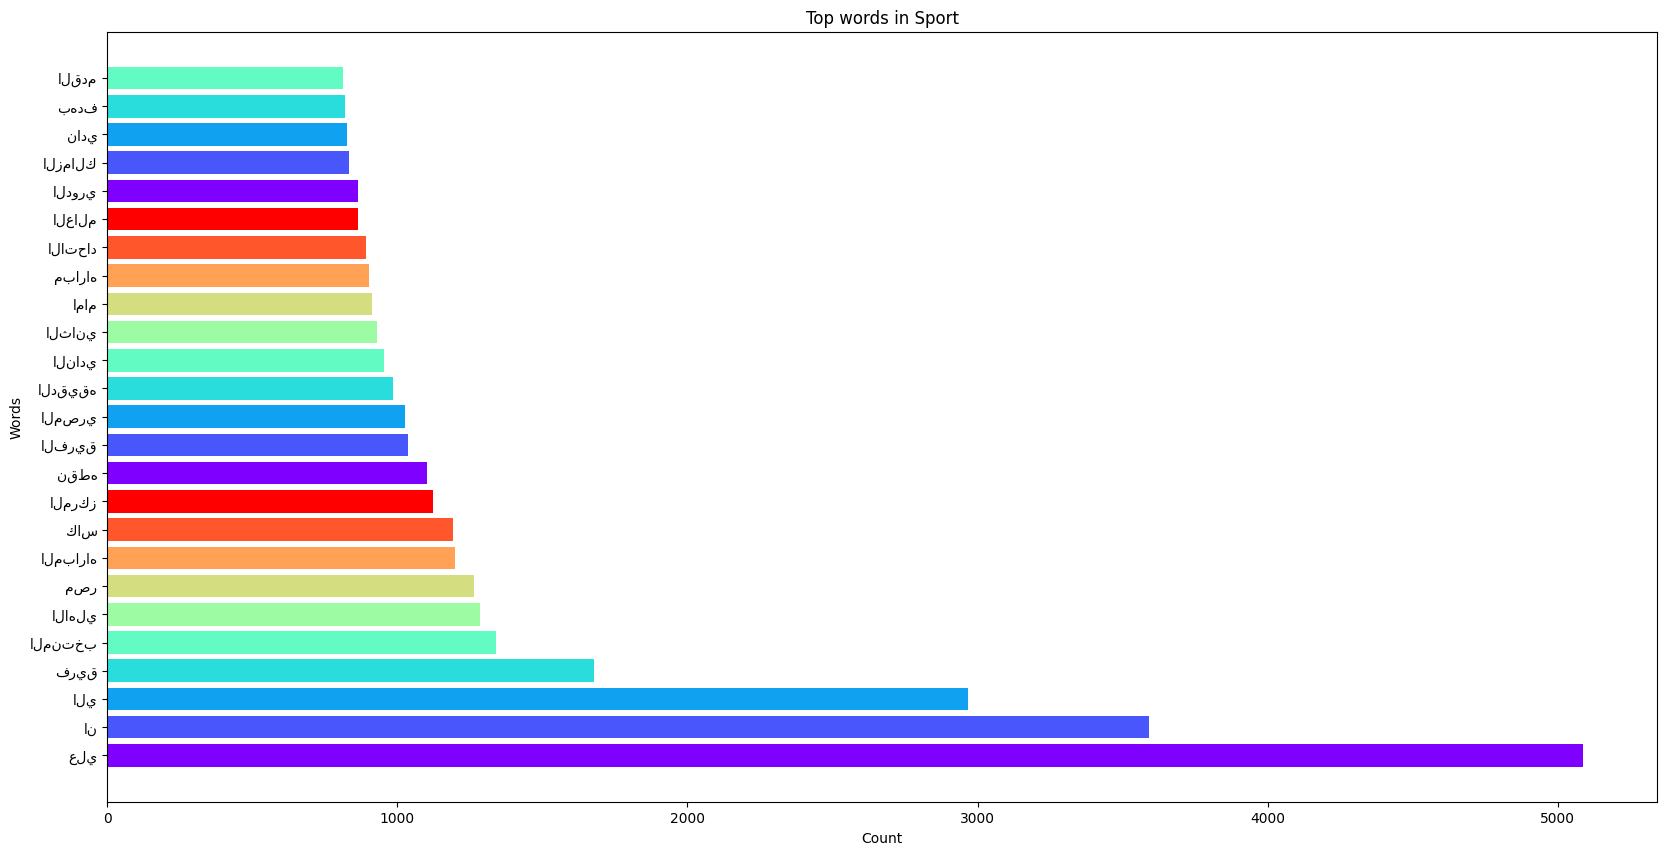

In [ ]:
plot(sport_words, 'Top words in Sport')

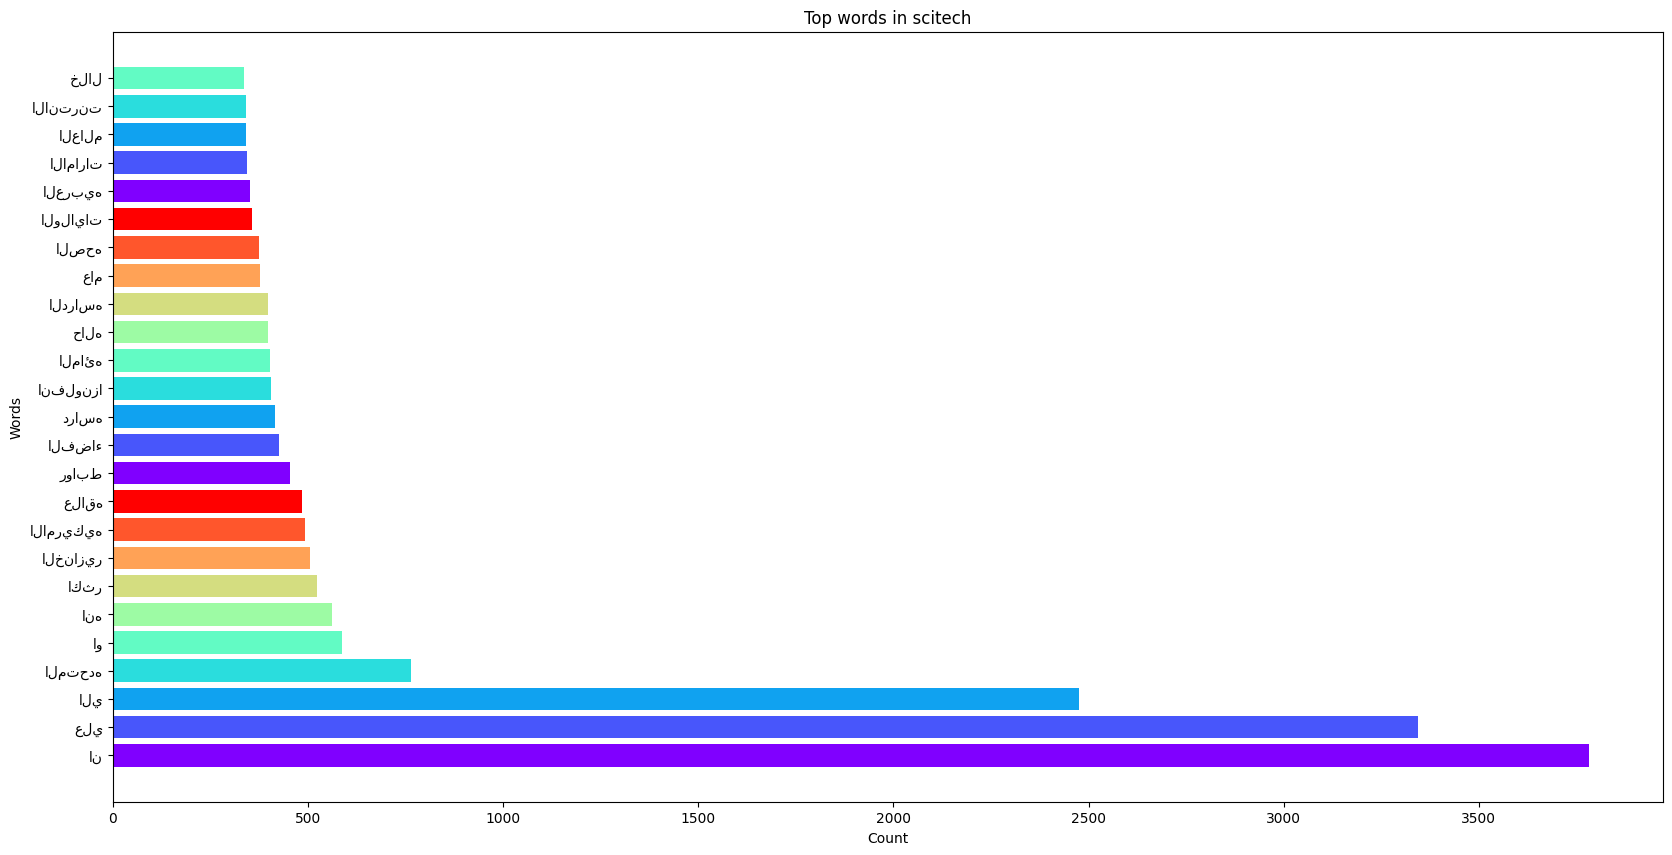

In [ ]:
plot(scitech_words, 'Top words in scitech')

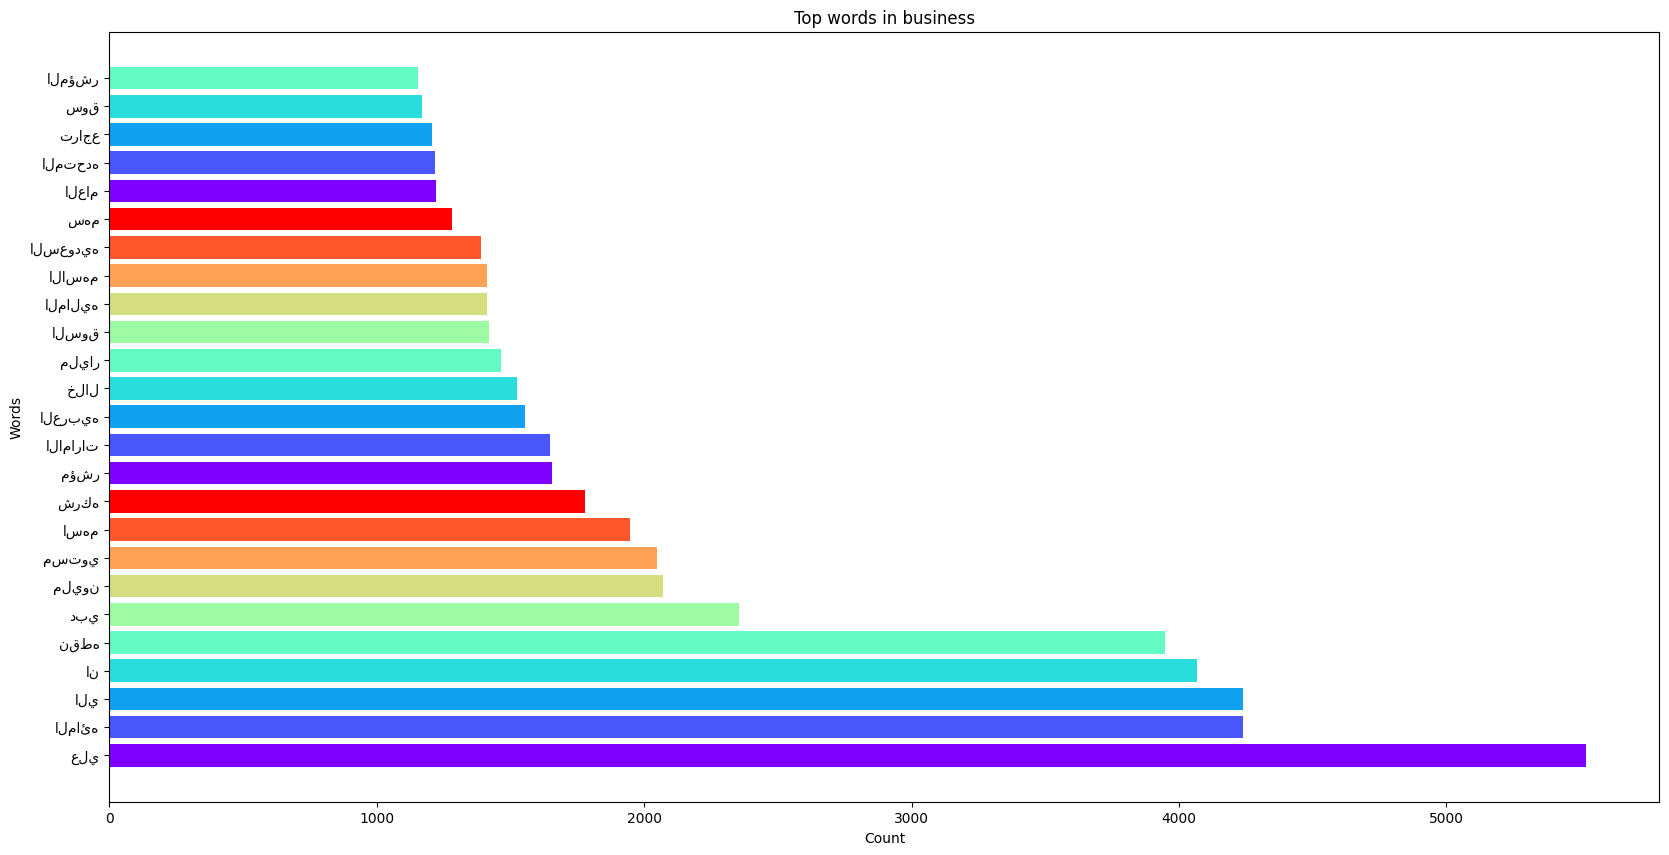

In [ ]:
plot(business_words, 'Top words in business')

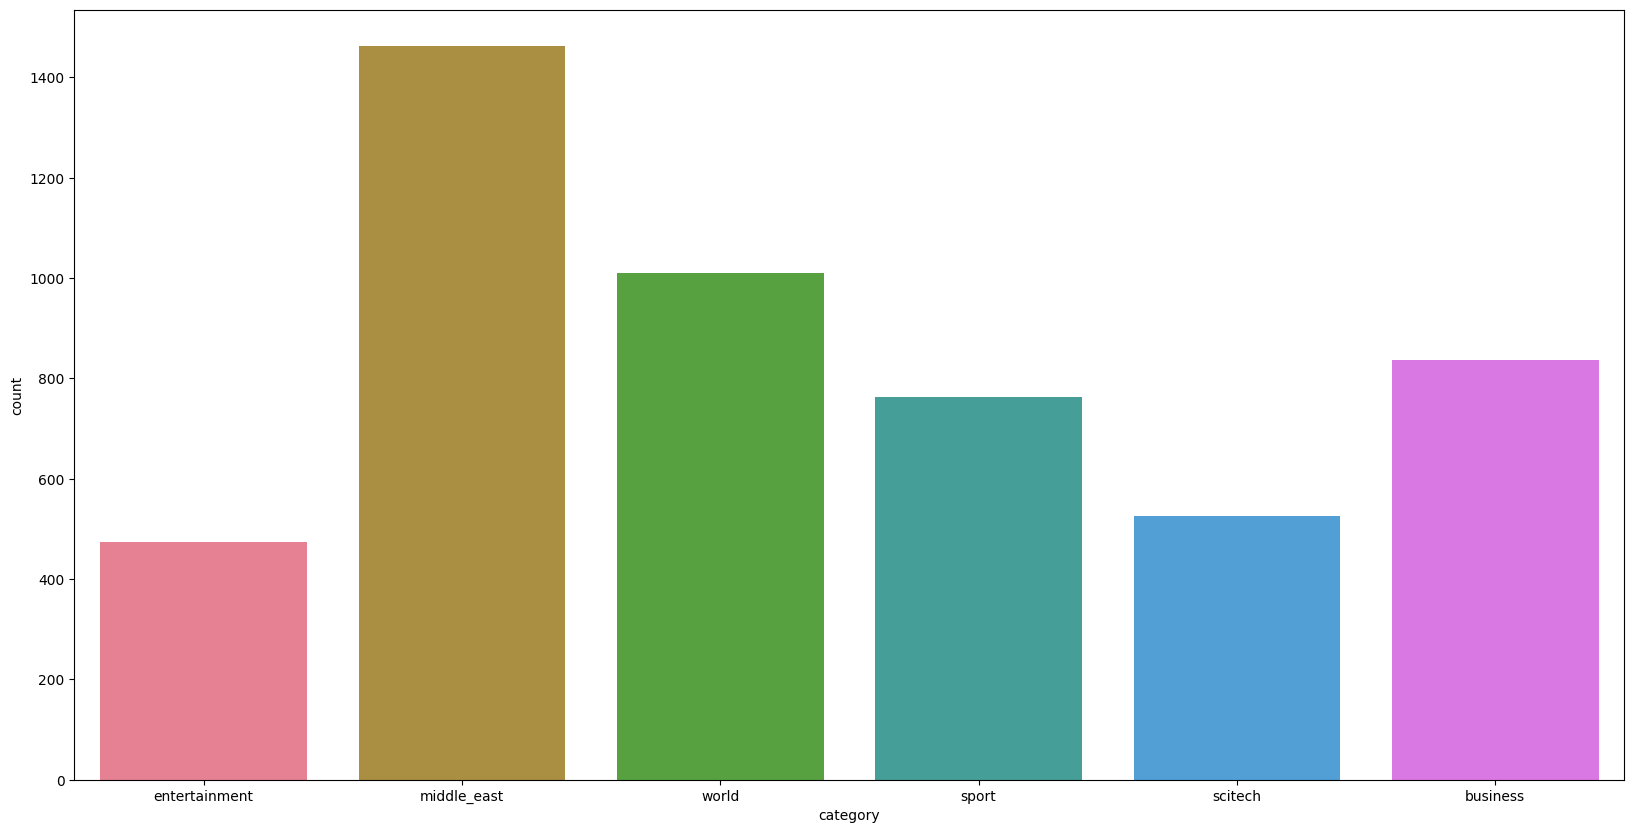

In [ ]:
# Définir la palette de couleurs
palette = sns.color_palette("husl", len(clean_df['category'].unique()))

# Afficher le countplot avec la palette de couleurs spécifiée
sns.countplot(data=clean_df, x="category", palette=palette)
plt.show()

#Machine learing model training

In [ ]:
y = clean_df['category']
X = clean_df['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features =10000)

In [ ]:
model = Pipeline([
                    ("tfidf", word_vectorizer), # convert words to numbers using tfidf
                    ("clf", SVC()) # model the text
])

# Fit the pipeline to the training data
model.fit(X_train.astype('str'), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf', SVC())])

In [ ]:
dump(model, "svm_model.joblib")

['svm_model.joblib']

#Model Evaluation

In [ ]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

y_pred = model.predict(X_test.astype('str'))
result = calculate_results(y_test, y_pred)
result

{'accuracy': 94.4006309148265,
 'precision': 0.9437867376087307,
 'recall': 0.944006309148265,
 'f1': 0.9434732677740466}

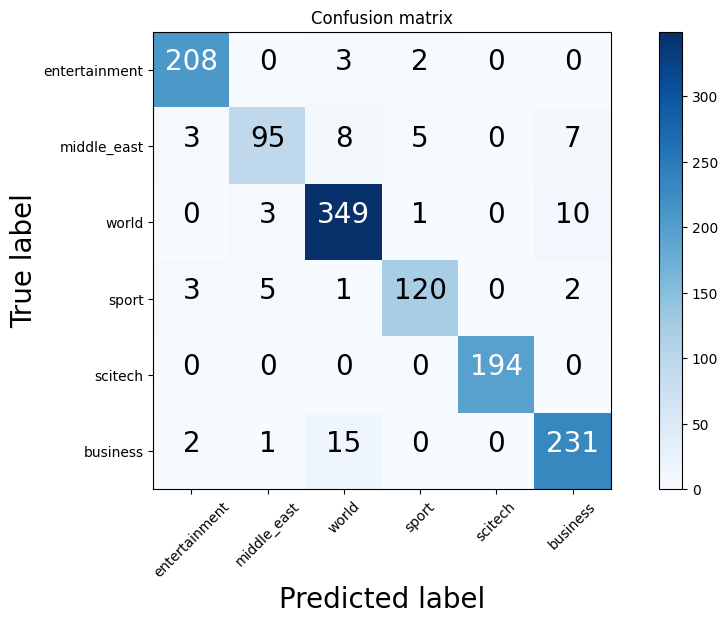

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['entertainment', 'middle_east', 'world', 'sport', 'scitech','business'])

#make predictions

In [ ]:
import joblib
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd

# Charger le modèle SVM pré-entraîné
model = joblib.load("svm_model.joblib")

def preprocess_text(text):
    # Tokenisation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Suppression des mots vides
    stopwords_list = set(stopwords.words('arabic'))
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords_list]

    # Rejoindre les tokens en une seule chaîne de caractères
    processed_text = ' '.join(filtered_tokens)

    return processed_text

def predict_category(text):
    # Prétraiter le texte
    preprocessed_text = preprocess_text(text)

    # Effectuer la prédiction
    category = model.predict([preprocessed_text])[0]

    return category

# Texte d'exemple à classer
text_to_classify = "تجه أسعار الذهب، اليوم الجمعة، للانخفاض للأسبوع الثاني على التوالي، وسط ترقب المستثمرين لبيانات اقتصادية بالولايات المتحدة."
# Prédire la catégorie du texte
predicted_category = predict_category(text_to_classify)
print("Catégorie prédite:", predicted_category)


Catégorie prédite: business
